# Notebook for the analysis of the solution trajectories

### Load all libraries and modules

In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json
import sys

from utils.exact import exact_RK, pendulum
from utils.plotting import Plotting, get_optimal_figsize, legend_without_duplicate_labels, init_plot_style
from utils.pathlib_helper import FileProcessing

from utils.solution_analysis import residuals_from_y, bandpower, get_theta_start_stop
from utils.exact import exact_RK
from matplotlib.ticker import FuncFormatter

init_plot_style(use_tex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the json files containing the PINN prediction

#### How to use it:
- use glob patterns to load all desired results easily (https://en.wikipedia.org/wiki/Glob_(programming))
- '*': match any number of characters
- '**': match all folders and files within that directory.

- Matched results are listed with their corresponding index for accessing them
  - Results with the same specifications but different seeds for weight initialization are grouped (indicated by '... | x Number | ... ')

In [51]:
log_path = Path(Path.cwd(), '', 'logs',)  

search_path = Path('simi*', '**',
                #    'y0=[2.618*', '**',
                   't_* 5]_*', '**',
                   'lambda_*IC_1_*', '**'
                  )

FileProcessing_ = FileProcessing(log_path, search_path)
FileProcessing_.preprocessing_data_loading()
FileProcessing_.group_files(data_extension='*json')

c:\Users\sophi\Documents\GitHub\PINNs-code-cleaned\logs
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.461,2.461,0,0]\t_[0, 5]_norm_[-5, 5]\full_[0, 5]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  0  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.478,2.478,0,0]\t_[0, 5]_norm_[-5, 5]\full_[0, 5]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  1  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.496,2.496,0,0]\t_[0, 5]_norm_[-5, 5]\full_[0, 5]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  2  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\similar_y0\vanilla\y0=[2.513,2.513,0,0]\t_[0, 5]_norm_[-5, 5]\full_[0, 5]x0\6x30\lambda_IC_1_data_1 | x  1  | Idx:  3  | 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Load the data

In [63]:
access_index = [0] #np.arange(16)
data = FileProcessing_.load_grouped_files(index=access_index)   

****************************** Data Loaded! ******************************


### Plotting the solution trajectories 

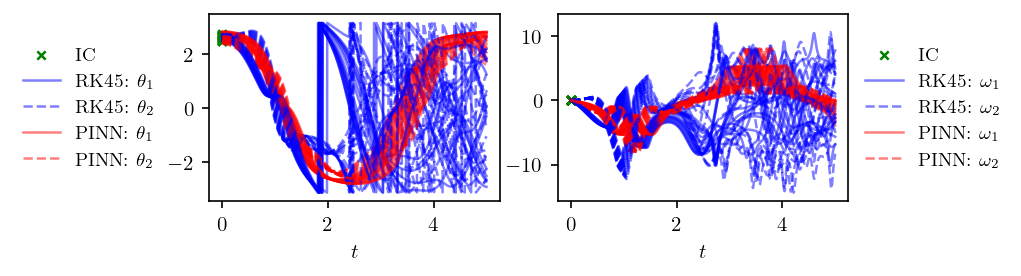

In [46]:
fig, axes = plt.subplots(1, 2, figsize=get_optimal_figsize(scale=1, height_factor=.3))
axes = axes.flatten()

for log in data: 
    Plot = Plotting(log, use_tex=True, alpha=0.5)
    Plot.plotting_yt_sol(axes[0:])
legend_without_duplicate_labels(axes[0], (-0.7, 0.5), idx = [-1, 0, 1, 2, 3], loc='center left');
legend_without_duplicate_labels(axes[1], (1, 0.5), idx = [-1, 0, 1, 2, 3], loc='center left');



### Compute the measures for the analysis of the solution trajectories
1. The distribution of the solutions' frequency components, namely, the amount of low-frequency components
   
$$
    P_{f_0} = \frac{\sum_{k>k_{f_0}} |X_k|^2}{\sum_k |X_k|^2}
$$
where $X_k$ denotes the discrete Fourier transform (DFT) of a signal $x(t_n)$ (in our experiments, $\theta_1,~\theta_2$) and $k_{f_0}$ denotes the DFT index corresponding to the boundary frequency $f_0$. 

2. the average magnitude of the second order derivatives, which are approximated using the central finite difference method 
$$
    \overline{|\theta_1''|}+\overline{|\theta_2''|} = \sum\limits_{i=1}^2 \frac{1}{N}\sum\limits_{n=1}^N \left| \frac{\delta_h^2 [ \theta_i](n_h)  }{h^2} \right| 
$$

Create a meshgrid of initial angles

In [47]:
theta_1_vec = np.arange(130,165,1)
theta_2_vec = np.arange(130,165,1)

theta_1_rad = theta_1_vec*np.pi/180
theta_2_rad = theta_1_vec*np.pi/180
th1_rad_mesh, th2_rad_mesh = np.meshgrid(theta_1_rad, theta_2_rad, indexing='ij')

y_grid = []
for row_th1, row_th2 in zip(th1_rad_mesh, th2_rad_mesh):
    y = [ [col_th1, col_th2, 0, 0]  for col_th1, col_th2 in zip(row_th1, row_th2)]
    y_grid.append(y)


Compute both analysis measures using the RK solution for given initial angles

In [53]:
# VARIABLES

xmax = 5
f0 = 0.5

#-------------------------------------------------------------------------
N = 1000 
x = np.linspace(0, xmax, N)
d = []

for y0_row in y_grid:
    for y0 in y0_row:
        y_rk = exact_RK(x, y0)
        (res_1_mean, res_2_mean, deriv_1_mean, deriv_2_mean) = residuals_from_y(y_rk,x,xmax)

        T = xmax/len(y_rk[0,:])
        pow_RK45, yf_RK45_list, f_RK45 = bandpower(y_rk[0:2,:], 1/T, f0=f0)

        dict_temp = {'res_1_mean':res_1_mean,
                     'res_2_mean':res_2_mean,
                     'deriv_1_mean':deriv_1_mean,
                     'deriv_2_mean':deriv_2_mean,
                     'bandpower': pow_RK45/2,
                     'xmax': xmax,
                     'y0': y0
        }

        d.append(dict_temp)

df = pd.DataFrame(d)
df['deriv_mean'] = df['deriv_1_mean']+df['deriv_2_mean']
df['th_1'] = df['y0'].apply(lambda x: np.round( x[0]*180/np.pi, 2) )
df['th_2'] = df['y0'].apply(lambda x: np.round( x[1]*180/np.pi, 2) )



### Plotting the analysis measures 

Select which measure to plot via the variable `values`:
1. 'bandpower'
2. 'deriv_mean'

bandpower_t_max_5_lambda_1


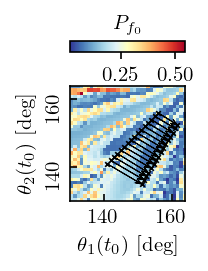

In [60]:
# VARIABLES

values = 'bandpower'    # bandpower deriv_mean

#-------------------------------------------------------------------------
# Prepare plotting
table = pd.pivot_table(df,values=values,index=['th_2'], columns=["th_1"], aggfunc=lambda x:x)
pinn_theta_start, pinn_th1_final, pinn_th2_final = get_theta_start_stop(data)
lambda_IC = data[0]['lambda_IC']

#-------------------------------------------------------------------------
# Heatmap with arrows point from the true IC to the predicted IC of the PINN solution
fig, axes = plt.subplots(1,1,figsize=get_optimal_figsize(scale=.3))
axes.tick_params(axis="y",direction="in")
axes.tick_params(axis="x",direction="in")

# heatmap
heatmap = axes.imshow(table, cmap ="RdYlBu_r", extent=[theta_1_vec.min(),theta_1_vec.max(),theta_2_vec.max(), theta_2_vec.min()])
# colorbar settings
cax = fig.add_axes([0.28, 1.1, .465,.07])
fmt = lambda x, pos: '{:.2f}'.format(x)
cbar_res = fig.colorbar(heatmap, format=FuncFormatter(fmt), cax=cax, pad=0.04, orientation="horizontal")
cbar_res.ax.set_title('$P_{f_0}$', rotation=0, fontsize=10)
cbar_res.ax.tick_params(axis="y",direction="in", rotation=90)
# axis labels
axes.invert_yaxis()
axes.tick_params(axis='y', labelrotation = 90)
axes.set_xlabel(r'$\theta_1{(t_0)}$ [deg]')
axes.set_ylabel(r'$\theta_2{(t_0)}$ [deg]')

# scatter plot and arrows
axes.scatter(pinn_theta_start,pinn_theta_start,c='k',marker='x', s=5, lw=.8)
axes.scatter(pinn_th1_final,pinn_th2_final,c='k',marker='x', s=5, lw=.8)
for x_start, y_start, x_final, y_final in zip(pinn_theta_start, pinn_theta_start, pinn_th1_final-pinn_theta_start, pinn_th2_final-pinn_theta_start):
    axes.arrow(x_start, y_start, x_final, y_final,overhang=0.9, lw=0.5, length_includes_head=True, head_width=1.3, fc='k')

#-------------------------------------------------------------------------
# specify name for saving the plot 
plot_name = '{}_t_max_{}_lambda_{}'.format(values, xmax, lambda_IC)
print(plot_name)
# plt.savefig(Path('', 'plots', plot_name+'.pdf'), bbox_inches='tight', transparent=True)
